In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 1 2 1 0 2 1 0 1 0 2 0 0 0 2 0 2 0 0 2 1 0 2 0 2 1 2]


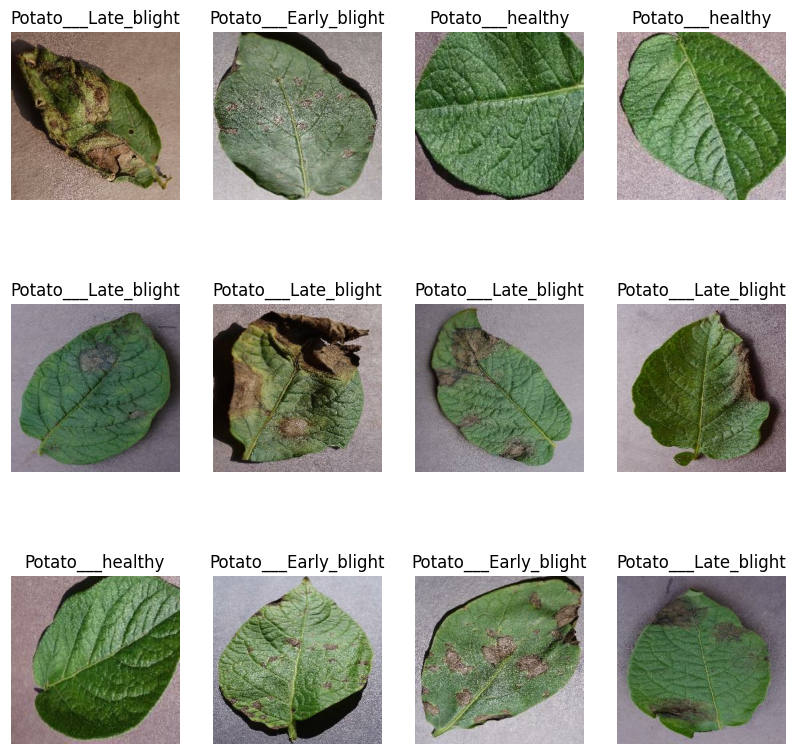

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

94

In [ ]:
train_size = 0.8
len(dataset)*train_size

75.2

In [ ]:
train_ds = dataset.take(75)
len(train_ds)

75

In [ ]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [ ]:
val_size=0.1
len(dataset)*val_size

9.4

In [ ]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  75
Validation Dataset Size:  9
Test Dataset Size:  10


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='sgd',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
75/75 [==============================] - 176s 1s/step - loss: 1.0961 - accuracy: 0.3821 - val_loss: 1.0898 - val_accuracy: 0.4653
Epoch 2/50
75/75 [==============================] - 100s 1s/step - loss: 1.0848 - accuracy: 0.5230 - val_loss: 1.0712 - val_accuracy: 0.6493
Epoch 3/50
75/75 [==============================] - 100s 1s/step - loss: 1.0573 - accuracy: 0.5640 - val_loss: 1.0269 - val_accuracy: 0.5139
Epoch 4/50
75/75 [==============================] - 99s 1s/step - loss: 1.0065 - accuracy: 0.5196 - val_loss: 0.9035 - val_accuracy: 0.6215
Epoch 5/50
75/75 [==============================] - 100s 1s/step - loss: 0.9465 - accuracy: 0.5393 - val_loss: 1.1548 - val_accuracy: 0.3576
Epoch 6/50
75/75 [==============================] - 98s 1s/step - loss: 0.9145 - accuracy: 0.5485 - val_loss: 0.7376 - val_accuracy: 0.7188
Epoch 7/50
75/75 [==============================] - 94s 1s/step - loss: 0.8603 - accuracy: 0.5778 - val_loss: 0.9787 - val_accuracy: 0.4688
Epoch 8/50
75/75

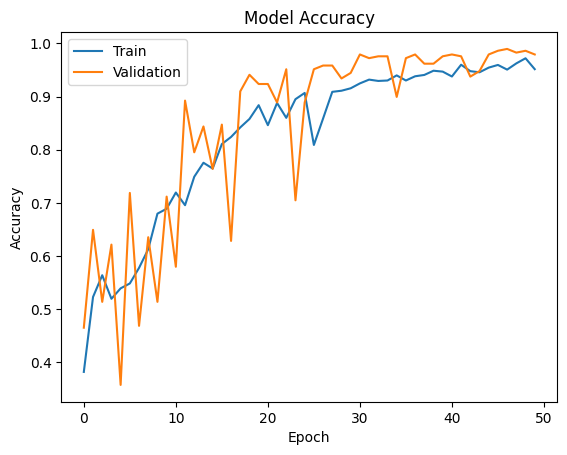

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

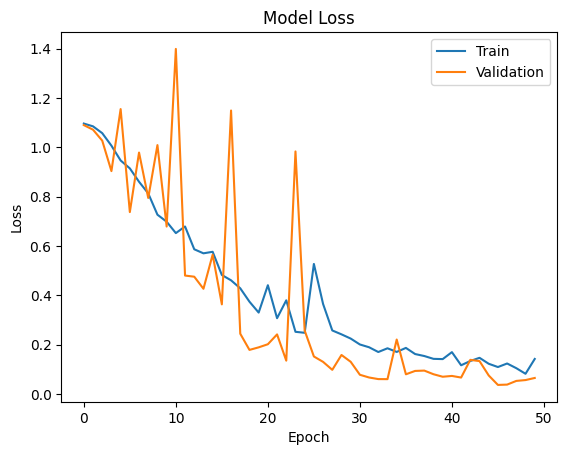

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

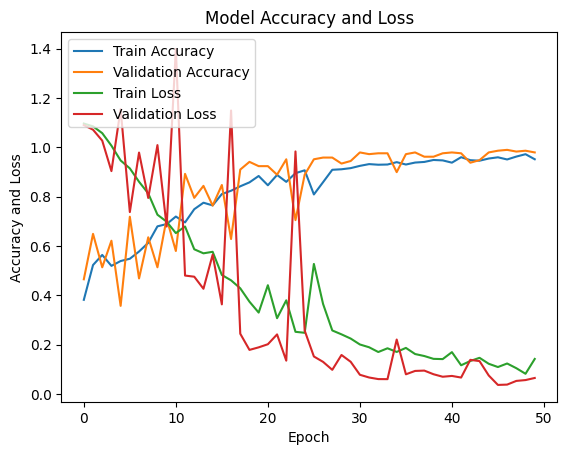

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

10/10 [==============================] - 2s 41ms/step - loss: 0.1238 - accuracy: 0.9563


[0.3821070194244385,
 0.5229933261871338,
 0.5639632344245911,
 0.5196488499641418,
 0.5392976403236389,
 0.5484949946403503,
 0.5777592062950134,
 0.6128762364387512,
 0.6797658801078796,
 0.6889632344245911,
 0.7194815874099731,
 0.695652186870575,
 0.7491638660430908,
 0.7755016684532166,
 0.7646321058273315,
 0.8106187582015991,
 0.8239966630935669,
 0.8419732451438904,
 0.8578595519065857,
 0.8837792873382568,
 0.8461538553237915,
 0.8879598379135132,
 0.8599498271942139,
 0.8950669169425964,
 0.9067725539207458,
 0.8089464902877808,
 0.8586956262588501,
 0.9088628888130188,
 0.910953164100647,
 0.9155518412590027,
 0.9247491359710693,
 0.9318562150001526,
 0.929347813129425,
 0.9301839470863342,
 0.9397993087768555,
 0.9301839470863342,
 0.9381271004676819,
 0.9406354427337646,
 0.9485785961151123,
 0.946906328201294,
 0.9377090334892273,
 0.9598662257194519,
 0.9477424621582031,
 0.945652186870575,
 0.954431414604187,
 0.9594481587409973,
 0.9506688714027405,
 0.9623745679855347

In [ ]:
history.history['val_accuracy']

[0.4652777910232544,
 0.6493055820465088,
 0.5138888955116272,
 0.6215277910232544,
 0.3576388955116272,
 0.71875,
 0.46875,
 0.6354166865348816,
 0.5138888955116272,
 0.7118055820465088,
 0.5798611044883728,
 0.8923611044883728,
 0.7951388955116272,
 0.84375,
 0.7638888955116272,
 0.8472222089767456,
 0.6284722089767456,
 0.9097222089767456,
 0.9409722089767456,
 0.9236111044883728,
 0.9236111044883728,
 0.8888888955116272,
 0.9513888955116272,
 0.7048611044883728,
 0.8888888955116272,
 0.9513888955116272,
 0.9583333134651184,
 0.9583333134651184,
 0.9340277910232544,
 0.9444444179534912,
 0.9791666865348816,
 0.9722222089767456,
 0.9756944179534912,
 0.9756944179534912,
 0.8993055820465088,
 0.9722222089767456,
 0.9791666865348816,
 0.9618055820465088,
 0.9618055820465088,
 0.9756944179534912,
 0.9791666865348816,
 0.9756944179534912,
 0.9375,
 0.9479166865348816,
 0.9791666865348816,
 0.9861111044883728,
 0.9895833134651184,
 0.9826388955116272,
 0.9861111044883728,
 0.9791666865348

In [ ]:
history.history['loss']

[1.0961027145385742,
 1.0848109722137451,
 1.0572714805603027,
 1.0064772367477417,
 0.9465412497520447,
 0.9145119786262512,
 0.8603353500366211,
 0.8132454752922058,
 0.7269566059112549,
 0.6985688805580139,
 0.6523705720901489,
 0.6792210340499878,
 0.5868769884109497,
 0.5704769492149353,
 0.5766634345054626,
 0.4826918840408325,
 0.4611346423625946,
 0.4287559986114502,
 0.3745625913143158,
 0.330433189868927,
 0.44127872586250305,
 0.30769842863082886,
 0.3801251947879791,
 0.25254958868026733,
 0.2485360950231552,
 0.5275521278381348,
 0.3652937412261963,
 0.2580205202102661,
 0.24227160215377808,
 0.2251768857240677,
 0.20123566687107086,
 0.1899556964635849,
 0.1707133650779724,
 0.18579643964767456,
 0.17102858424186707,
 0.18736772239208221,
 0.1625288724899292,
 0.15444304049015045,
 0.14300411939620972,
 0.14200866222381592,
 0.17021258175373077,
 0.11701087653636932,
 0.13430020213127136,
 0.1472434103488922,
 0.1230865940451622,
 0.10985282063484192,
 0.12420011311769485

In [ ]:
history.history['val_loss']

[1.0898295640945435,
 1.0711948871612549,
 1.0269174575805664,
 0.903462827205658,
 1.154768466949463,
 0.7375575304031372,
 0.9787033796310425,
 0.7946480512619019,
 1.0088179111480713,
 0.6789982914924622,
 1.398442268371582,
 0.4803529977798462,
 0.47581011056900024,
 0.4268658459186554,
 0.5649702548980713,
 0.36375153064727783,
 1.1489745378494263,
 0.24477659165859222,
 0.17927119135856628,
 0.1895950585603714,
 0.20222227275371552,
 0.2420022189617157,
 0.13571971654891968,
 0.9831678867340088,
 0.2575039267539978,
 0.15261812508106232,
 0.13077938556671143,
 0.09852293133735657,
 0.15869802236557007,
 0.13109365105628967,
 0.07852012664079666,
 0.0674862414598465,
 0.061032142490148544,
 0.06078000366687775,
 0.22126662731170654,
 0.08045660704374313,
 0.09407073259353638,
 0.09542812407016754,
 0.08068476617336273,
 0.07054483890533447,
 0.07383677363395691,
 0.06725679337978363,
 0.13899767398834229,
 0.13387611508369446,
 0.07570220530033112,
 0.037407632917165756,
 0.038709

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.956250011920929
Loss:  0.12375886738300323


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

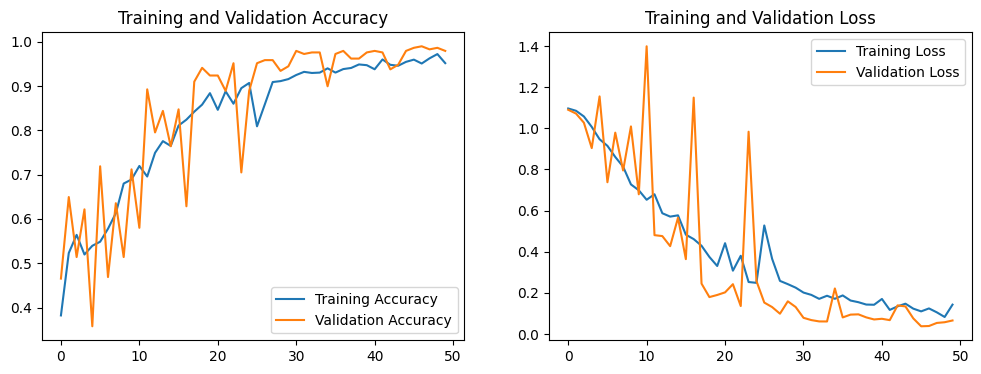

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___healthy
1/1 [==============================] - 0s 213ms/step
[8.4134456e-08 1.3725854e-04 9.9986267e-01]
Max Value: 2
Predicted Label: Potato___healthy


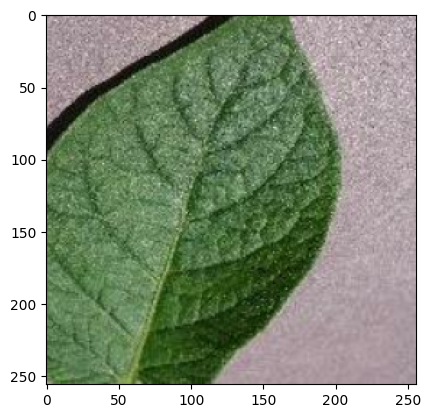

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


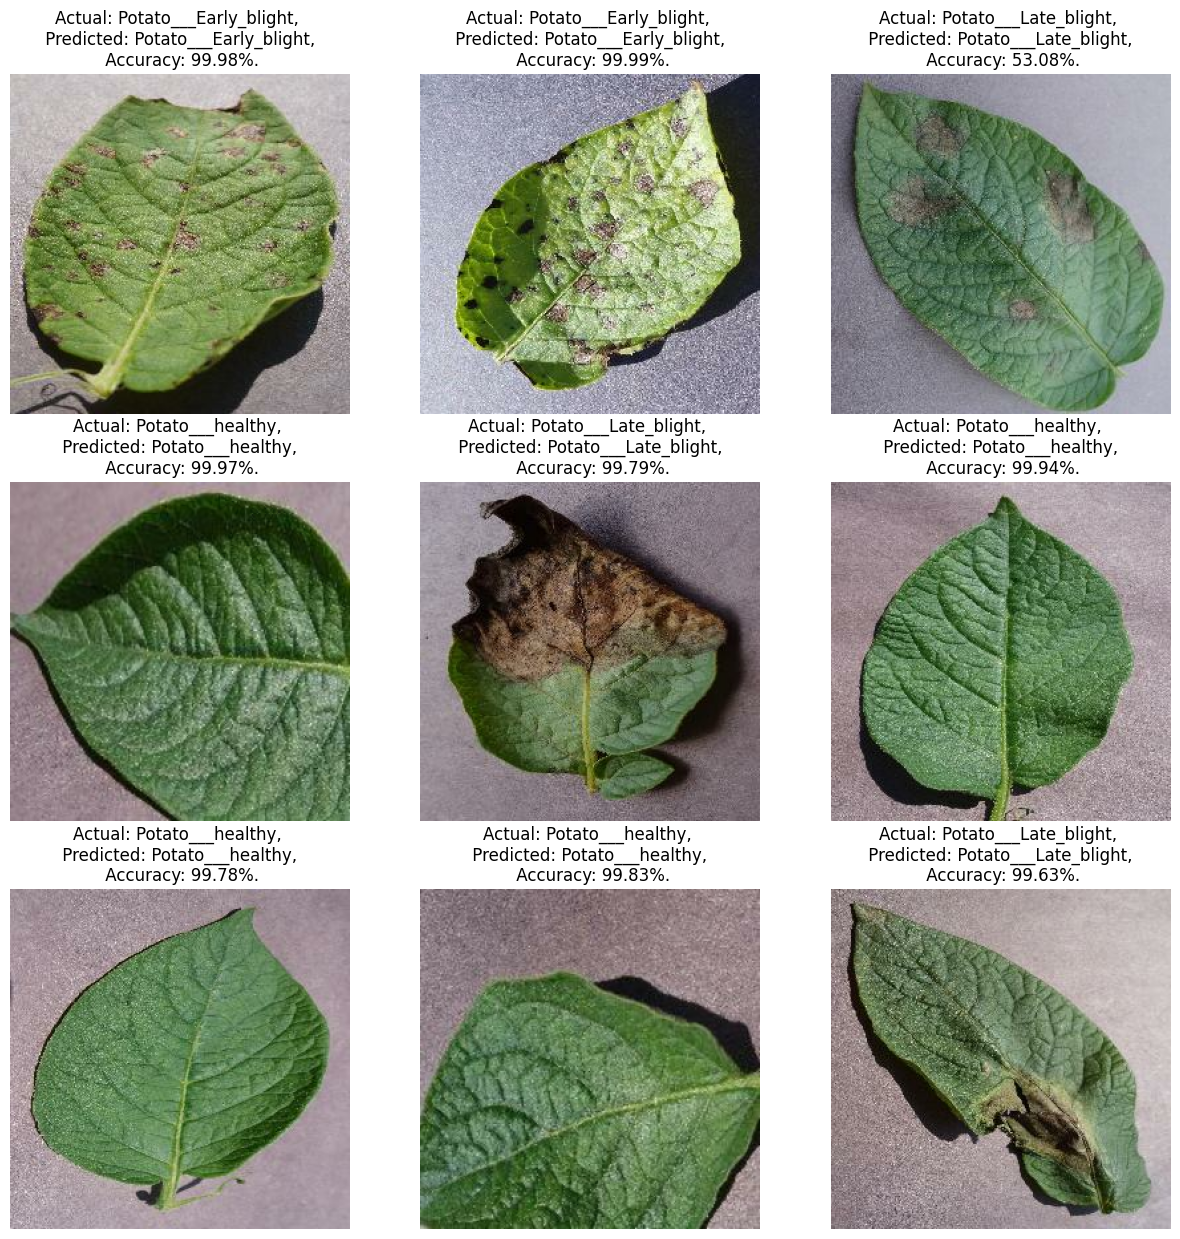

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  95.6250011920929


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

10/10 [==============================] - 0s 35ms/step
F1 Score:  43.173044703318226
Precision Score:  43.38145163980916
Recall Score:  43.125


10/10 [==============================] - 0s 34ms/step


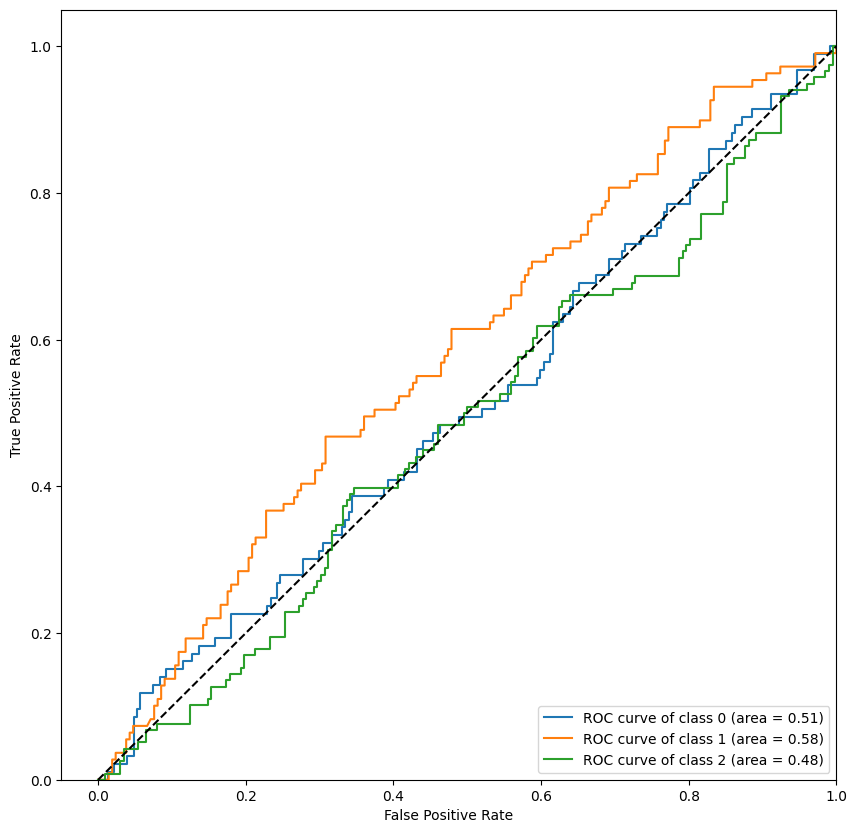

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

10/10 [==============================] - 0s 34ms/step


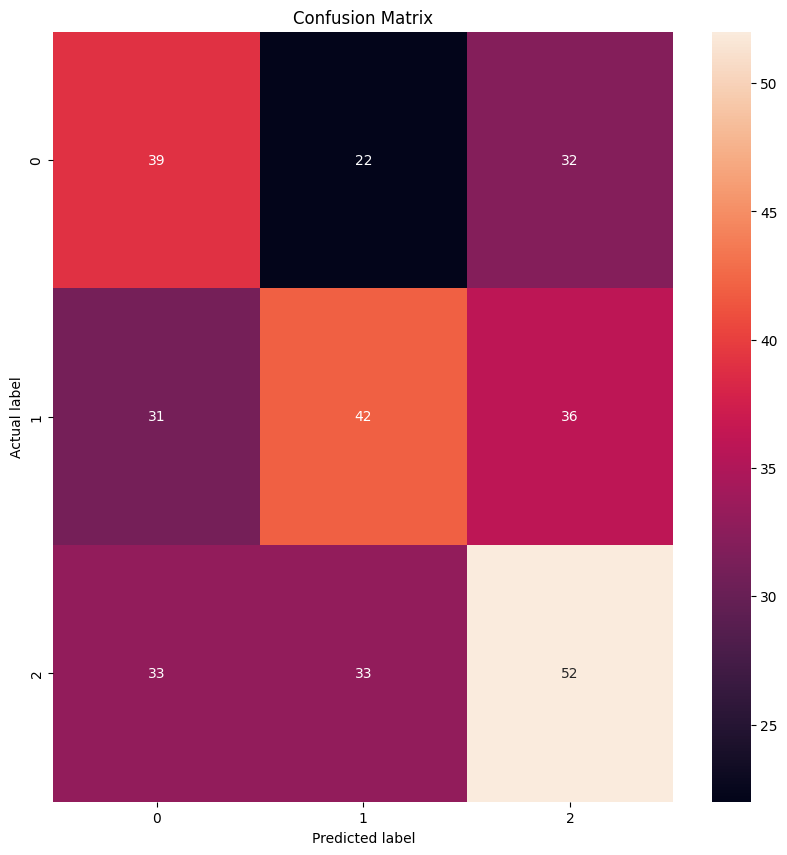

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()